## **Análisis de Series de Tiempo - Trabajo Final**

## Gustavo Uñapillco       Código: a1624



## **Primera Parte**

### a. Limpieza y Preparación de Datos


In [ ]:
#INSTALACIÓN DE LIBRERÍAS

# 1. Reinstalar numpy y pandas en versiones compatibles con TensorFlow y Colab
!pip install numpy==1.26.4 pandas==2.2.2 --quiet

# 2. Instalar pmdarima sin que reinstale numpy/pandas incompatibles
!pip install pmdarima --no-deps --force-reinstall --no-cache-dir --quiet

# 3. Instalar el resto de librerías (sin tocar numpy/pandas)
!pip install matplotlib scikit-learn tabulate pandas-market-calendars statsmodels arch keras joblib --quiet


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
thinc 8.3.6 requires numpy<3.0.0,>=2.0.0, but you have numpy 1.26.4 which is incompatible.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 151.4 MB/s eta 0:00:00


In [ ]:
import os
os.kill(os.getpid(), 9)  # Reinicia el entorno para aplicar correctamente las actualizaciones

In [ ]:
#IMPORTACIÓN DE LIBRERÍAS

# -------------------------
# Utilidades generales
# -------------------------
from datetime import datetime, timedelta
import os
import glob
import warnings
warnings.filterwarnings('ignore')

# -------------------------
# Manejo y procesamiento de datos
# -------------------------
import pandas as pd
import numpy as np
from tabulate import tabulate
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# -------------------------
# Visualización
# -------------------------
import matplotlib.pyplot as plt

# -------------------------
# Calendario de mercados
# -------------------------
import pandas_market_calendars as mcal

# -------------------------
# Estadística y series temporales
# -------------------------
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_predict
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima.model import ARIMA as sm_ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
from pmdarima.arima import ARIMA as pm_ARIMA
import pmdarima as pm
from arch import arch_model

# -------------------------
# Modelado con LSTM
# -------------------------
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

#from keras.preprocessing.sequence import TimeseriesGenerator

# -------------------------
# Paralelización
# -------------------------
from joblib import parallel_backend


#### 1. Contexto y fuente de datos

Trabajaremos con datos históricos del índice futuro E-mini Nasdaq 100 (MNQ), los cuales han sido descargados/exportados desde la plataforma NinjaTrader.

**Los datos exportados estarán en la zona horaria UTC.**

Los datos correspondien al contrato MNQ 09-24:

| index    | contract    | start       | expires     | file                              |
|----------|-------------|-------------|-------------|-----------------------------------|
| 18       | MNQ 09-24   | 24-06-2024  | 20-09-2024  | ./Datos_MNQ/18_MNQ 09-24.Last.txt |

Con registros minuto a minuto en formato OHLCV, que incluye:

 - Open: precio de apertura
- High: precio máximo
- Low: precio mínimo
- Close: precio de cierre
- Volume: volumen negociado


#### 2. Carga de dataframe

In [86]:
!git clone https://github.com/GUNAPILLCO/AST1_Trabajo_Final-

fatal: destination path 'AST1_Trabajo_Final-' already exists and is not an empty directory.


In [88]:
df_mnq = pd.read_parquet('AST1_Trabajo_Final-/mnq_2024.parquet')

In [89]:
# Resultado
df_mnq.head()

,open,high,low,close,volume
datetime,,,,,
2024-06-24 03:01:00,19950.00,19952.50,19949.75,19950.75,139
2024-06-24 03:02:00,19950.75,19952.75,19950.75,19952.50,91
2024-06-24 03:03:00,19952.50,19956.00,19952.50,19955.50,149
2024-06-24 03:04:00,19955.50,19959.50,19955.00,19958.00,309
2024-06-24 03:05:00,19958.00,19959.00,19957.50,19958.50,95


#### 3. Preparación de Datos

Primero veamos cuantas muestras tengo en total:


In [35]:
print(f'Tengo {len(df_mnq)} muestras')

Tengo 88216 muestras


##### 3.1. Filtrado de fines de semana y feriados bursátiles estadounidenses

Necesito filtrar los datos de los sabados, domingos y feriados, usaré la librería pandas_market_calendars para este fin


In [36]:
def filter_nasdaq_weekdays(df):
    """
    Filters a DataFrame with a DatetimeIndex, keeping only rows whose date corresponds to
    a weekday in the NASDAQ market calendar. The complete timestamp (date and time) is preserved.
    """
    # Create NASDAQ calendar
    nasdaq = mcal.get_calendar('NASDAQ')

    # Get the date range from the DataFrame
    start_date = df.index.min().date()
    end_date = df.index.max().date()

    # Get the market schedule (only weekdays)
    market_schedule = nasdaq.schedule(start_date=start_date, end_date=end_date)

    # Extract valid weekdays (without time)
    valid_dates = set(market_schedule.index.date)

    # Create a series of dates from the index, preserving the time
    fechas_index = pd.Series(df.index.date, index=df.index)

    # Filter the DataFrame
    df_filtered = df[fechas_index.isin(valid_dates)]

    return df_filtered

In [37]:
df_mnq = filter_nasdaq_weekdays(df_mnq)

##### 3.2. Filtrado de horario de operación de mercado de New York (09:30 a 16:00) con pre mercado, desde las 08:30

Primero necesito indicarle a pandas que los timestamps del indice TimedateIndex están en **UTC**, ya que al ser leídos desde un archivo .txt no contiene información sobre la zona horaria.

Luego necesito convertir los timestamps desde UTC a la hora local del mercado de EE.UU. (NASDAQ/NYSE), ajustando automáticamente por horario de verano o invierno.

In [38]:
def set_timezone_and_convert(df, from_tz='UTC', to_tz='America/New_York'):
    """
    Asegura que el índice del DataFrame tenga zona horaria 'from_tz'
    y lo convierte a la zona horaria 'to_tz'.
    """
    if df.index.tz is None:
        # Localiza en from_tz si no tiene zona horaria
        df.index = df.index.tz_localize(from_tz)
    # Convierte a la zona horaria deseada
    df.index = df.index.tz_convert(to_tz)
    return df

In [39]:
df_mnq = set_timezone_and_convert(df_mnq)

In [40]:
def filter_nasdaq_trading_hours(df):
    """
    Filtra un DataFrame con un DatetimeIndex para conservar solo las filas que están dentro
    del horario de negociación del NASDAQ (de 09:30 a 16:00) y que corresponden a los días hábiles del NASDAQ.
    """
    # Filtrar solo las filas dentro de las horas de mercado (de 8:30 AM a 4:00 PM)
    df_filtered = df.between_time('08:30:00', '16:00:00')

    # Retornar el DataFrame filtrado
    return df_filtered

In [41]:
df_mnq = filter_nasdaq_trading_hours(df_mnq)

##### 3.3. Análisis de registros diarios

Necesito asegurarme de que todos los días tengan la misma cantidad de registros y que dichos registros sean consecutivos, es decir, que no falte ningún minuto en el día.

**Primero veamos cuantos registros tenemos por día**

In [42]:
def analizar_registros_por_dia(df: pd.DataFrame):
    """
    Analiza la cantidad de registros por día en un DataFrame con índice datetime.

    Muestra:
    - Distribución de la cantidad de registros por día (sin metadatos extra).
    - Porcentaje de días con menos registros que el valor esperado.

    Parámetros:
    - df: DataFrame con índice datetime.
    - registros_esperados: Número de registros esperados por día (por defecto 391).
    """
    print("Distribución de cantidad de registros por día:\n")

    # Contar la cantidad de registros por día
    conteo_diario = df.groupby(df.index.date).size()
    distribucion = conteo_diario.value_counts().sort_index(ascending=False)

    # Preparar los datos para la tabla
    tabla = []
    for registros, cantidad_dias in distribucion.items():
        tabla.append([registros, cantidad_dias])

    # Imprimir la tabla
    print(tabulate(tabla, headers=["Registros por día", "Cantidad de días"], tablefmt="grid"))

    '''
    # Calcular el porcentaje de días con menos registros
    total_dias = len(conteo_diario)
    dias_con_menos = (conteo_diario < registros_esperados).sum()
    porcentaje = (dias_con_menos / total_dias) * 100

    # Mostrar el porcentaje
    print(f"\nDías con menos de {registros_esperados} registros: {dias_con_menos} de {total_dias} ({porcentaje:.2f}%)")
    '''

    return conteo_diario

In [43]:
conteo_diario = analizar_registros_por_dia(df_mnq)

Distribución de cantidad de registros por día:

+---------------------+--------------------+
|   Registros por día |   Cantidad de días |
+=====================+====================+
|                 451 |                 56 |
+---------------------+--------------------+
|                 449 |                  1 |
+---------------------+--------------------+
|                 448 |                  1 |
+---------------------+--------------------+
|                 444 |                  1 |
+---------------------+--------------------+
|                 443 |                  1 |
+---------------------+--------------------+
|                 440 |                  1 |
+---------------------+--------------------+
|                 286 |                  1 |
+---------------------+--------------------+
|                  61 |                  1 |
+---------------------+--------------------+


In [44]:
registros_dia_completo = conteo_diario.mode().iloc[0]
print(registros_dia_completo)

451


In [45]:
# Calcular el porcentaje de días con menos registros
total_dias = len(conteo_diario)
dias_con_menos = (conteo_diario < registros_dia_completo).sum()
porcentaje = (dias_con_menos / total_dias) * 100

# Mostrar el porcentaje
print(f"Días con menos de {registros_dia_completo} registros: {dias_con_menos} de {total_dias} ({porcentaje:.2f}%)")


Días con menos de 451 registros: 7 de 63 (11.11%)


Como podemos observar en la tabla, la gran mayoría de días tienen 451 muestras. Y representan más del 89% del total de los datos.

Necesito encontrar los indices de esos días para poder filtrarlos.

In [46]:
def report_incomplete_or_irregular_days(df: pd.DataFrame, gap_minutes: int = 1, registros_esperados: int = registros_dia_completo) -> list:
    """
    Muestra una tabla con los días que tienen menos de los registros esperados o presentan irregularidades temporales.
    Retorna una lista con esas fechas.

    Parámetros:
    - df: DataFrame con índice datetime.
    - gap_minutes: intervalo esperado entre registros consecutivos (en minutos).
    - registros_esperados: cantidad esperada de registros por día.

    Retorna:
    - Lista de fechas (datetime.date) con menos registros de los esperados o problemas temporales.
    """
    df = df.copy()
    df['time_diff'] = df.index.to_series().diff()
    base_time_diff = pd.Timedelta(minutes=gap_minutes)

    conteos = df.groupby(df.index.date).size()
    fechas_problema = []

    for date, group in df.groupby(df.index.date):
        time_diff = group['time_diff'].iloc[1:]
        tiene_irregularidades = (time_diff != base_time_diff).any()
        cantidad = conteos[date]

        if cantidad < registros_esperados or tiene_irregularidades:
            fechas_problema.append((date, cantidad))

    if fechas_problema:
        print(f"\nDía con menos de {registros_esperados} registros o con problemas temporales:\n")
        print(f"{'+' + '-'*21 + '+' + '-'*20 + '+'}")
        print(f"| {'Fecha'.ljust(19)} | {'Registros'.rjust(18)} |")
        print(f"{'+' + '='*21 + '+' + '='*20 + '+'}")
        for fecha, registros in fechas_problema:
            print(f"| {str(fecha).ljust(19)} | {str(registros).rjust(18)} |")
            print(f"{'+' + '-'*21 + '+' + '-'*20 + '+'}")
    else:
        print("No se encontraron días con irregularidades ni registros incompletos.")

    # Solo devolver las fechas
    return [fecha for fecha, _ in fechas_problema]

In [47]:
fechas_con_problemas = report_incomplete_or_irregular_days(df_mnq)


Día con menos de 451 registros o con problemas temporales:

+---------------------+--------------------+
| Fecha               |          Registros |
+=====================+====================+
| 2024-07-03          |                286 |
+---------------------+--------------------+
| 2024-07-19          |                440 |
+---------------------+--------------------+
| 2024-07-25          |                444 |
+---------------------+--------------------+
| 2024-08-02          |                443 |
+---------------------+--------------------+
| 2024-08-05          |                449 |
+---------------------+--------------------+
| 2024-09-19          |                448 |
+---------------------+--------------------+
| 2024-09-20          |                 61 |
+---------------------+--------------------+


Elimino los registros correspondientes a esas fechas de mi dataset

In [48]:
# Filtrar eliminando las fechas con problemas
df_mnq = df_mnq[~df_mnq.index.to_series().dt.date.isin(fechas_con_problemas)]


Verifico que mi dataset tenga todos los días con 391 registros.

In [49]:
#Verifico
conteo_diario = analizar_registros_por_dia(df_mnq)
fechas_con_problemas = report_incomplete_or_irregular_days(df_mnq)

Distribución de cantidad de registros por día:

+---------------------+--------------------+
|   Registros por día |   Cantidad de días |
+=====================+====================+
|                 451 |                 56 |
+---------------------+--------------------+
No se encontraron días con irregularidades ni registros incompletos.


**Luego, verifiquemos que esos 451 registros sean consecutivos**

In [50]:
def check_intraday_minute_gaps(df: pd.DataFrame, gap_minutes: int = 1):
    """
    Verifica si existen saltos mayores al intervalo esperado (por defecto 1 minuto)
    entre registros consecutivos dentro de cada día, en un DataFrame con índice tipo DatetimeIndex.

    Omite el primer registro de cada día.

    Parámetros:
    - df: DataFrame con índice datetime.
    - gap_minutes: tamaño esperado del intervalo en minutos (por defecto 1).

    Retorna:
    - Lista de índices donde se detectaron diferencias mayores al intervalo esperado.
    """
    df = df.copy()
    df['time_diff'] = df.index.to_series().diff()

    base_time_diff = pd.Timedelta(minutes=gap_minutes)
    problem_indices = []

    for date, group in df.groupby(df.index.date):
        time_diff = group['time_diff'].iloc[1:]
        incorrect_indices = time_diff[time_diff != base_time_diff].index
        if len(incorrect_indices) > 0:
            problem_indices.append(incorrect_indices)

    if problem_indices:
        print(f"Se encontraron problemas en {len(problem_indices)} registros con diferencias irregulares.\n")

        # Conteo por fecha
        conteos = df.groupby(df.index.date).size()

        for i in range(len(problem_indices)):
            idx = problem_indices[i][0]
            diff = df.loc[idx, 'time_diff']
            date = idx.date()
            count = conteos[date]
            print(f'\t{idx} -> Diferencia: {diff} | # Registros: {count}')
    else:
        print("No se encontraron problemas, todas las muestras son consecutivas minuto a minuto.")

    return problem_indices

In [51]:
problem_indices = check_intraday_minute_gaps(df_mnq)

No se encontraron problemas, todas las muestras son consecutivas minuto a minuto.


In [52]:
df_mnq.head(100)


,open,high,low,close,volume
datetime,,,,,
2024-06-24 08:30:00-04:00,19964.75,19966.75,19964.00,19965.75,236
2024-06-24 08:31:00-04:00,19966.25,19967.50,19957.75,19959.25,730
2024-06-24 08:32:00-04:00,19958.75,19959.00,19955.00,19958.00,763
2024-06-24 08:33:00-04:00,19958.50,19958.75,19953.25,19956.00,531
2024-06-24 08:34:00-04:00,19956.00,19960.50,19954.75,19957.00,661
...,...,...,...,...,...
2024-06-24 10:05:00-04:00,19970.75,19980.75,19967.00,19976.25,3963
2024-06-24 10:06:00-04:00,19975.75,19978.00,19961.25,19965.00,3575
2024-06-24 10:07:00-04:00,19964.75,19974.25,19960.00,19973.00,2583


In [53]:
df_mnq.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 25256 entries, 2024-06-24 08:30:00-04:00 to 2024-09-18 16:00:00-04:00
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   open    25256 non-null  float64
 1   high    25256 non-null  float64
 2   low     25256 non-null  float64
 3   close   25256 non-null  float64
 4   volume  25256 non-null  int32  
dtypes: float64(4), int32(1)
memory usage: 1.1 MB


#### 4. Estacionaridad y Estacionalidad

Dado que mis datos son minuto a minuto, y exclusivamente dentro del horario bursátil y sólo en días hábiles, debo tener en cuenta que hay una **estructura intradía** muy marcada y eso afecto cómo analizo la estacionariedad.

**¿Qué implica mi estructura de datos?**

- No hay continuidad entre días: el cierre de un día y la apertura del siguiente están separados por varias horas (y fines de semana).
- Estacionalidad intradía: muchos activos financieros siguen patrones repetitivos dentro del día (ej. más volatilidad en apertura y cierre).
- No es una serie temporal completamente regular: aunque sea minuto a minuto, tiene cortes diarios.

Emplearé distintas estrategias para analizar esto:

##### 4.1. Análisis ADF aplicado sobre la serie 'close' día por día.

Uso una prueba de estacionariedad (como ADF) sobre close

In [58]:
def aplicar_adf_por_dia(df, columna, min_muestras=391):
    """
    Aplica la prueba ADF día por día sobre una columna de una serie temporal.

    Parámetros:
    - df: DataFrame con índice datetime.
    - columna: Nombre de la columna a analizar.
    - min_muestras: Número mínimo de muestras por día para aplicar ADF.

    Retorna:
    - DataFrame con estadístico ADF, p-value y si es estacionaria por día.
    """
    # Asegura que el índice sea datetime
    if not pd.api.types.is_datetime64_any_dtype(df.index):
        raise ValueError("El índice del DataFrame debe ser de tipo datetime.")

    # Agrega columna de fecha sin hora
    df = df.copy()
    df['fecha'] = df.index.date

    resultados_adf = {}

    for fecha, grupo in df.groupby('fecha'):
        serie = grupo[columna].dropna()
        if len(serie) >= min_muestras:
            try:
                resultado = adfuller(serie)
                resultados_adf[fecha] = {
                    'ADF Statistic': resultado[0],
                    'p-value': resultado[1],
                    'stationary': resultado[1] < 0.05
                }
            except Exception as e:
                resultados_adf[fecha] = {
                    'ADF Statistic': None,
                    'p-value': None,
                    'stationary': None,
                    'error': str(e)
                }

    return pd.DataFrame.from_dict(resultados_adf, orient='index')

In [59]:
def resumen_estacionariedad(df_adf):
    """
    Resume la proporción y cantidad de días estacionarios y no estacionarios
    a partir de un DataFrame con una columna 'stationary' (bool).

    Parámetros:
    - df_adf: DataFrame con una columna 'stationary' (True o False)

    Imprime:
    - Cantidad y proporción de días estacionarios y no estacionarios
    """
    conteo_abs = df_adf['stationary'].value_counts()
    conteo_rel = df_adf['stationary'].value_counts(normalize=True)

    estacionarios = conteo_abs.get(True, 0)
    no_estacionarios = conteo_abs.get(False, 0)
    prop_estacionarios = conteo_rel.get(True, 0)
    prop_no_estacionarios = conteo_rel.get(False, 0)

    print(f"Días estacionarios (True): {estacionarios} ({prop_estacionarios:.2%})")
    print(f"Días no estacionarios (False): {no_estacionarios} ({prop_no_estacionarios:.2%})")

Creo una columna con la columna fecha para diferenciar los registros por día.

In [60]:
df_mnq['fecha'] = df_mnq.index.date  # extrae solo la fecha

Aplico el análisis ADF a la serie 'close'

In [61]:
df_close_adf = aplicar_adf_por_dia(df_mnq, columna='close', min_muestras=391)
resumen_estacionariedad(df_close_adf)

Días estacionarios (True): 5 (8.93%)
Días no estacionarios (False): 51 (91.07%)


Como resultado obtengo que la serie día por día, en su gran mayoría (casi el 90%) son **no estacionarios**, es decir hay tendencia o componente no constante.

##### 4.2. Aplico diferenciación simple día por día a la serie 'close'

Una primera transformación clásica es calcular las diferencias entre minutos consecutivos. Esto suele eliminar la tendencia.

**Ojo que tengo datos día por día, no debería calcular diferencias entre días distintos**

In [62]:
df_mnq['close_diff'] = df_mnq.groupby('fecha')['close'].diff()

Si aplico una diferenciación día por día, el primero registro de cada día tendrá un valor NaN.

In [63]:
def observar_nan(df, serie = 'close_diff'):
    # Extraer las fechas únicas del índice
    dias_unicos = df.index.normalize().nunique()
    print(f"Número de días únicos en la serie: {dias_unicos}")

    nan_total = df[serie].isna().sum()
    print(f"Cantidad de valores NaN en close_diff: {nan_total}")

In [64]:
observar_nan(df_mnq)

Número de días únicos en la serie: 56
Cantidad de valores NaN en close_diff: 56


Decido reemplazar esos NaN por ceros, ya que al ser un solo registro y el primero de todos los días no tiene demasiada influencia..

In [65]:
df_mnq['close_diff'] = df_mnq['close_diff'].fillna(0)
observar_nan(df_mnq)


Número de días únicos en la serie: 56
Cantidad de valores NaN en close_diff: 0


Ahora que no tengo valores NaN en mi serie, puedo aplicar el análisis ADF a la serie 'close_diff'

In [66]:
df_close_diff_adf = aplicar_adf_por_dia(df_mnq, columna='close_diff', min_muestras=391)
resumen_estacionariedad(df_close_diff_adf)

Días estacionarios (True): 56 (100.00%)
Días no estacionarios (False): 0 (0.00%)


Como resultado obtenemos que todos los días son **estacionarios**, lo que quiere decir que se elimino la tendencia, pero aún puede haber estacionalidad intradía.

##### 4.3. Estacionalidad

In [67]:
def descomposicion_ets(serie, period=registros_dia_completo, model='additive', nombre_serie='close'):
    """
    Realiza descomposición ETS y analiza residuos para una serie temporal.

    Parámetros:
    -----------
    serie : pd.Series
        Serie temporal (debe tener índice datetime con frecuencia uniforme).
    period : int
        Periodicidad estacional (ej: 391 para datos intradía).
    model : str
        'additive' o 'multiplicative'.
    nombre_serie : str
        Nombre descriptivo de la serie (para los títulos).
    """
    try:
        # Asegura frecuencia constante y rellena NaN si es necesario
        serie = serie.asfreq('T').fillna(method='ffill')

        # Descomposición ETS
        result = seasonal_decompose(serie, model=model, period=period)

        # Graficar componentes
        plt.figure(figsize=(12, 8))
        result.plot()
        plt.suptitle(f'Descomposición ETS ({model}) - {nombre_serie}', y=1.02)
        plt.tight_layout()
        plt.show()

        # Métricas de tendencia y estacionalidad
        seasonal_amplitude = result.seasonal.max() - result.seasonal.min()
        print(f"\nMétricas para {nombre_serie} ({model}):")
        print(f"• Amplitud estacional: {seasonal_amplitude:.4f}")
        print(f"• Tendencia promedio: {result.trend.mean():.4f}")

        # Análisis de residuos
        residuos = result.resid.dropna()
        print(f"\nAnálisis de Residuos ETS:")
        print(f"• Media: {residuos.mean():.4f} (ideal: 0)")
        print(f"• Desviación estándar: {residuos.std():.4f} (menor = mejor)")
        print(f"• % dentro de ±2σ: {((residuos.abs() < 2*residuos.std()).mean()*100):.2f}%")

        return result

    except Exception as e:
        print(f"Error: {e}. Verifica frecuencia, NaN o tamaño insuficiente.")
        return None

**Descomposición ETS a serie 'close'**

<Figure size 1200x800 with 0 Axes>

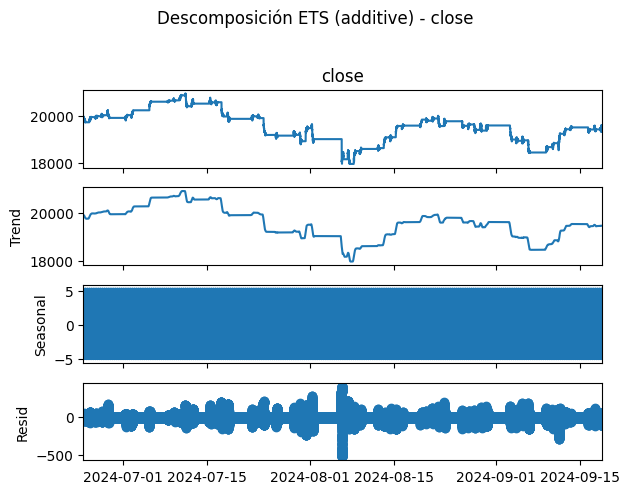


Métricas para close (additive):
• Amplitud estacional: 10.3064
• Tendencia promedio: 19567.4998

Análisis de Residuos ETS:
• Media: -0.0482 (ideal: 0)
• Desviación estándar: 34.6417 (menor = mejor)
• % dentro de ±2σ: 94.58%


In [68]:
ets_close = descomposicion_ets(df_mnq['close'])

**Descomposición ETS a serie 'close_diff'**

<Figure size 1200x800 with 0 Axes>

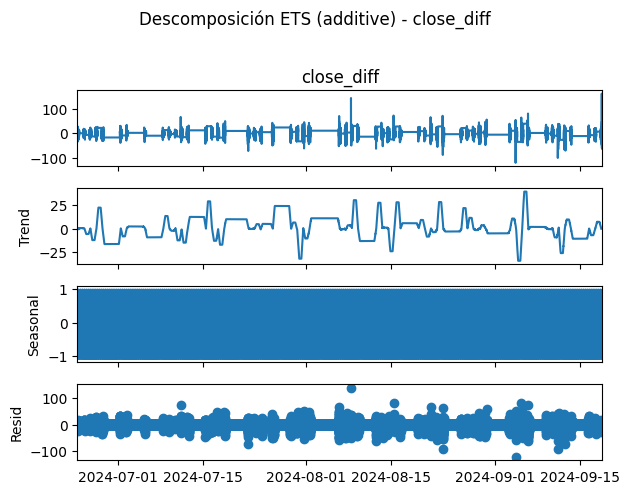


Métricas para close_diff (additive):
• Amplitud estacional: 2.0862
• Tendencia promedio: 1.1375

Análisis de Residuos ETS:
• Media: -0.0007 (ideal: 0)
• Desviación estándar: 5.1217 (menor = mejor)
• % dentro de ±2σ: 93.75%


In [69]:
# Aplicación de ETS a serie 'close_dIff'
ets_close_diff = descomposicion_ets(df_mnq['close_diff'], nombre_serie='close_diff' )

**Comparación de Descomposición ETS: `close` vs `close_diff`**

| Métrica                  | Serie `close`     | Serie `close_diff` | Interpretación |
|--------------------------|------------------|---------------------|----------------|
| **Amplitud Estacional**  | 10.3064           | 2.0862             | La diferenciación redujo la estacionalidad en ~78%, lo que sugiere mayor estabilidad. |
| **Tendencia Promedio**   | 19567.4998       | 1.1375              | La tendencia fue eliminada, indicando estacionariedad en media. |
| **Media de Residuos**    | -0.0482          | -0.0007             | Residuos más centrados en cero, mejor ajuste. |
| **Desviación Estándar**  | 34.6417          | 5.1217              | Disminución del ruido (~85%), lo que indica mayor precisión del modelo. |
| **% dentro de ±2σ**      | 94.58%           | 93.75%              | Ambas series tienen residuos dentro de márgenes aceptables; `close` levemente superior. |


La diferenciación simple aplicada a la serie `close` resultó en una serie `close_diff` con comportamiento más estacionario, menor estacionalidad y menor variabilidad. Esto la convierte en una mejor candidata para el entrenamiento de modelos estadísticos como **ARIMA**, al cumplir con los supuestos de estacionariedad y ruido blanco en los residuos.  

Aunque la serie original conserva un buen porcentaje de residuos dentro de ±2σ, `close_diff` muestra un ajuste más limpio y estadísticamente más consistente.

De todas me pregunto **¿Es necesario una diferenciación estacional?**, a continuación hago dos análisis para responder a esta duda.

**Análisis visual (ACF y PACF):**

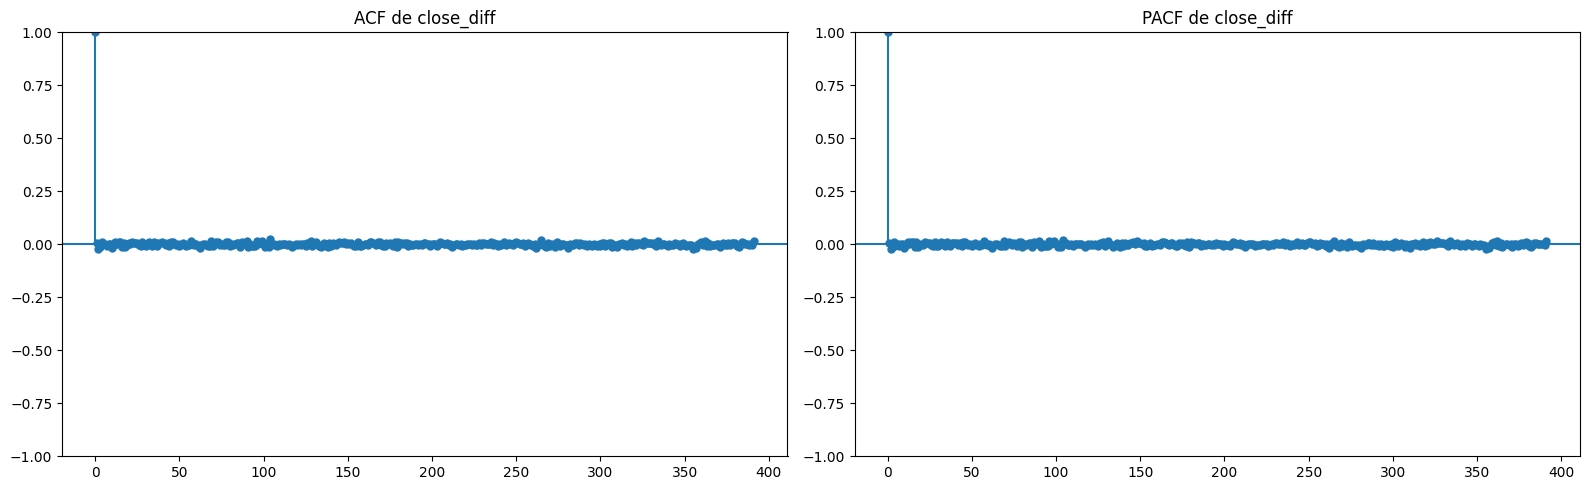

In [70]:
#Prueba Visual (Gráfico ACF)

import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Crear figura conjunta
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# ACF
plot_acf(df_mnq['close_diff'].dropna(), lags=391, ax=axes[0])
axes[0].set_title('ACF de close_diff')

# PACF
plot_pacf(df_mnq['close_diff'].dropna(), lags=391, ax=axes[1], method='ywm')
axes[1].set_title('PACF de close_diff')

plt.tight_layout()
plt.show()


**Análisis con métrica cuantitativa (Box Jenkins):**

In [71]:
# Enfoque Box-Jenkins para evaluar estacionalidad residual
# Usamos la amplitud estacional estimada desde ETS y la comparamos con un umbral del 2% del rango total

# Paso 1: Calcular el rango de la serie diferenciada
rango_close_diff = df_mnq['close_diff'].max() - df_mnq['close_diff'].min()

# Paso 2: Definir el umbral de estacionalidad (2% del rango, sugerencia del enfoque Box-Jenkins)
umbral_estacionalidad = 0.02 * rango_close_diff

# Paso 3: Ingresar la amplitud estacional estimada (por ejemplo, obtenida de ETS)
amplitud_estacional_estim = 2.0862  # Este valor deberías reemplazarlo por el que obtengas dinámicamente si deseas

# Paso 4: Comparar y decidir si aplicar D=1
aplicar_D1 = amplitud_estacional_estim > umbral_estacionalidad

# Mostrar resultados
print("Evaluación Box-Jenkins de estacionalidad residual:\n")
print(f"\tRango de la serie: {rango_close_diff:.4f}")
print(f"\tUmbral (2% del rango): {umbral_estacionalidad:.4f}")
print(f"\tAmplitud estacional estimada: {amplitud_estacional_estim:.4f}")
print(f"\n\t¿Aplicar diferenciación estacional (D=1)? {'Sí' if aplicar_D1 else 'No'}")

Evaluación Box-Jenkins de estacionalidad residual:

	Rango de la serie: 283.5000
	Umbral (2% del rango): 5.6700
	Amplitud estacional estimada: 2.0862

	¿Aplicar diferenciación estacional (D=1)? No


**Análisis de resultados:**

Gráfico ACF:
- No muestra picos significativos en lags múltiplos de 451 (periodicidad intradía)
- Los valores de autocorrelación se mantienen dentro de los límites de confianza (áreas sombreadas), lo que sugiere que no hay estacionalidad residual fuerte.

Amplitud Estacional (4.24):
- Es menor que el 2% del rango de close_diff (umbral calculado), confirmando que la estacionalidad residual es insignificante.

**Decido no aplicar diferenciación estacional (D=0), ya que la diferenciación simple (d=1) ya logró eliminar la tendencia no estacionaria y reducir la estacionalidad a niveles no significativos.**

### b. Creación de modelos de análisis de tiempo

#### 1. ARIMA

In [72]:
#Creo una copia de dataset df_mnq para el modelo ARIMA
df_arima = df_mnq.copy()

Busco el mejor modelo con auto ARIMA para mis datos

In [73]:
#Busco los mejores parametros con el autoarima

with parallel_backend('threading', n_jobs=4):  # Cambia n_jobs a 4 para usar 4 núcleos
    model_arima = pm.auto_arima(
        df_arima['close_diff'],
        seasonal=True,     # Hay una estacionalidad residual insignificante, pero la hay.
        #m=451,                   # Especificamos que el periodo estacional es de 451 (minutos por día)
        d=0,               # Ya está diferenciada
        trace=True,
        stepwise=True
    )

print(model_arima.summary())


Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=185586.487, Time=26.91 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=185599.780, Time=0.71 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=185600.441, Time=0.88 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=185600.376, Time=2.86 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=185598.223, Time=0.30 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=185588.950, Time=23.35 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=185588.540, Time=33.83 sec
 ARIMA(3,0,2)(0,0,0)[0] intercept   : AIC=185587.772, Time=38.37 sec
 ARIMA(2,0,3)(0,0,0)[0] intercept   : AIC=185587.872, Time=37.07 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=185603.760, Time=6.89 sec
 ARIMA(1,0,3)(0,0,0)[0] intercept   : AIC=185585.692, Time=16.95 sec
 ARIMA(0,0,3)(0,0,0)[0] intercept   : AIC=185586.444, Time=8.40 sec
 ARIMA(1,0,4)(0,0,0)[0] intercept   : AIC=185587.483, Time=6.34 sec
 ARIMA(0,0,2)(0,0,0)[0] intercept   : AIC=185589.396, Time=4.10 sec

El mejor modelo Arima para mis datos es:

In [74]:
print(model_arima.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                25256
Model:               SARIMAX(0, 0, 4)   Log Likelihood              -92786.975
Date:                Mon, 21 Apr 2025   AIC                         185583.949
Time:                        21:37:40   BIC                         185624.634
Sample:                             0   HQIC                        185597.111
                              - 25256                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.0074      0.004      1.697      0.090      -0.001       0.016
ma.L2         -0.0227      0.004     -5.524      0.000      -0.031      -0.015
ma.L3         -0.0137      0.005     -2.937      0.0

Hago una predicción:

In [75]:
def predicciones_arima(df, modelo, order=(0, 0, 4)):
    """
    Realiza predicciones para toda la serie temporal utilizando el modelo entrenado.

    Parámetros:
    -----------
    df : DataFrame con columnas 'close' y 'close_diff', index datetime.
    modelo : modelo ARIMA entrenado.

    Retorna:
    --------
    predicciones : Predicciones del modelo.
    reales : Valores reales.
    """
    # Realizar predicciones
    df['ar_pred_diff'] = modelo.predict_in_sample(start=0, end=len(df) - 1)

    # Reconstruir las predicciones de diferencia a precios reales
    df['ar_pred_close'] = np.cumsum(df['ar_pred_diff']) + df['close'].iloc[0]

        # Graficar las predicciones frente a los valores reales
    plt.figure(figsize=(10, 5))
    plt.plot(df['close'], label='close real')  # Valores reales
    plt.plot(df['ar_pred_close'], label='close ARIMA', linestyle='--')  # Predicciones
    plt.title("ARIMA - Predicción de 'close'")
    plt.xlabel('Tiempo')
    plt.ylabel('Precio Close')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    return df['ar_pred_close'], df['close']

Función para calcular el error de la predicción

In [76]:
def calcular_error_arima(predicciones, reales):
    """
    Calcula las métricas de error para las predicciones de un modelo.

    Parámetros:
    -----------
    predicciones : Serie de predicciones realizadas por el modelo.
    reales : Serie de valores reales.

    Retorna:
    --------
    Diccionario con las métricas de error.
    """
    # Error absoluto medio (MAE)
    mae = mean_absolute_error(reales, predicciones)

    # Error cuadrático medio (RMSE)
    rmse = np.sqrt(mean_squared_error(reales, predicciones))

    # Error porcentual absoluto medio (MAPE)
    mape = np.mean(np.abs((reales - predicciones) / reales)) * 100

    # Coeficiente de determinación (R^2)
    r2 = 1 - (np.sum((reales - predicciones)**2) / np.sum((reales - np.mean(reales))**2))

    metrics = {
        'MAE': mae,
        'RMSE': rmse,
        'MAPE': mape,
        'R²': r2
    }

    #Mostrar las métricas
    print(f"\nMétricas de error del modelo ARIMA (0,0,4) para la serie 'close':\n")
    print(f"\tMAE: {mae}")
    print(f"\tRMSE: {rmse}")
    print(f"\tMAPE: {mape}")
    print(f"\tR²: {r2}")


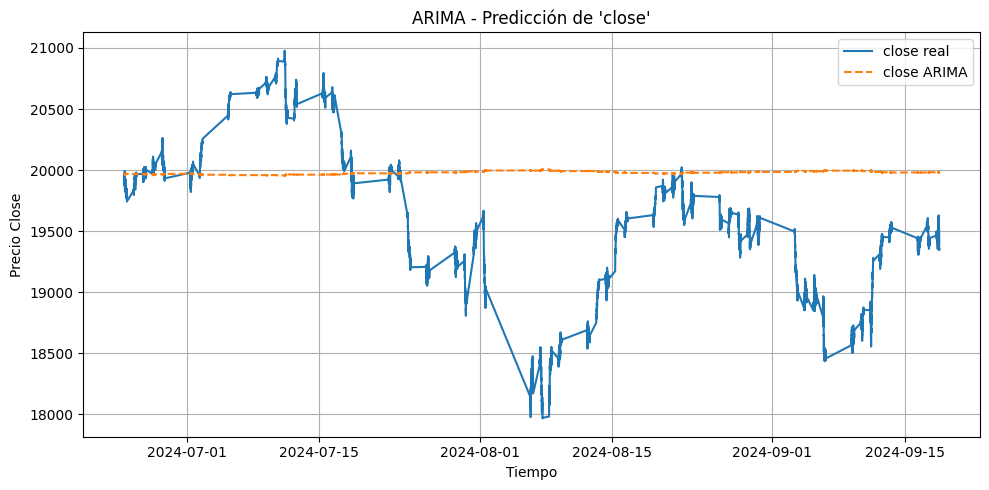


Métricas de error del modelo ARIMA (0,0,4) para la serie 'close':

	MAE: 625.5454810281567
	RMSE: 779.0262628266563
	MAPE: 3.257203559676751
	R²: -0.43531923571727016


In [77]:
# Realizar predicciones para toda la serie temporal
predicciones, reales = predicciones_arima(df_arima, model_arima)

# Calcular las métricas de error
calcular_error_arima(predicciones, reales)


#### 2. GARCH

El modelo GARCH (Generalized Autoregressive Conditional Heteroskedasticity) es útil para modelar la volatilidad de los precios en series temporales financieras, como los datos de precios de cierre.
Este modelo es muy útil cuando hay heterocedasticidad en los datos, es decir, cuando la varianza de los errores no es constante en el tiempo.

El modelo GARCH se usa generalmente sobre los retornos (o diferencias logarítmicas) de los precios, no sobre los precios en sí.

El modelo predice volatilidad, y veremos la volatilidad tanto de `close` como de `close_diff`.

In [ ]:
#Creo una copia del dataset df_mnq para el modelo GARCH
df_garch=df_mnq.copy()

##### 2.1. Calculo de retornos para `close` y `close_diff`.

In [ ]:
def calcular_retornos (df, serie: str, log_resultado: str) -> float:
    # Calcular los retornos logarítmicos de la serie 'close'
    df[log_resultado] = np.log(df[serie] / df[serie].shift(1))

    # Eliminar valores nulos generados por el cálculo de retornos
    df = df.dropna(subset=[log_resultado])

    # Calcular la volatilidad real (desviación estándar de los retornos)
    volatility_real = df[log_resultado].std()

    print(f"Volatilidad Real de la serie {serie}: {volatility_real}")

    return volatility_real

Calculamos los retornos reales tanto de `close` como de `close_diff`.

In [ ]:
volatility_real_close = calcular_retornos(df_garch, 'close', 'log_return_close')
volatility_real_close_diff = calcular_retornos(df_garch, 'close_diff', 'log_return_close_diff')

Volatilidad Real de la serie close: 0.0006356458026988104
Volatilidad Real de la serie close_diff: nan


Filtro los Inf y los NaN de las columnas `log_return_close` y `log_return_close_diff`, primero convierto lo Inf por NaN y luego elimino los NaN.

In [ ]:
# Reemplazar inf por NaN en las columnas 'log_return_close' y 'log_return_close_diff'
df_garch[['log_return_close', 'log_return_close_diff']] = df_garch[['log_return_close', 'log_return_close_diff']].replace([np.inf, -np.inf], np.nan)
# Eliminar valores nulos generados por el cálculo de retornos en las columnas específicas
df_garch = df_garch.dropna(subset=['log_return_close', 'log_return_close_diff'])

##### 2.2. Creación de modelos

Función para crear un modelo GARCH para `log_return_close` y `log_return_close_diff`:

In [ ]:
def create_garch_model (df, serie: str):
    # Ajustar el modelo GARCH(1, 1) a los retornos logarítmicos
    model = arch_model(df[serie], vol='Garch', p=1, q=1)
    model_fit = model.fit()
    print(f'\nSummary modelo {serie}:\n')
    print(model_fit.summary())

    return model_fit

In [ ]:
model_garch_close = create_garch_model(df_garch, 'log_return_close')

Iteration:      1,   Func. Count:      5,   Neg. LLF: -75889.42539924069
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -75889.42536289585
            Iterations: 1
            Function evaluations: 5
            Gradient evaluations: 1

Summary modelo log_return_close:

                     Constant Mean - GARCH Model Results                      
Dep. Variable:       log_return_close   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:                75889.4
Distribution:                  Normal   AIC:                          -151771.
Method:            Maximum Likelihood   BIC:                          -151741.
                                        No. Observations:                12062
Date:                Sun, Apr 20 2025   Df Residuals:                    12061
Time:                        21:16:51   Df Model:     

c:\Users\Gus\miniconda3\envs\trader_IA\lib\site-packages\arch\univariate\base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


In [ ]:
model_garch_close_diff = create_garch_model(df_garch, 'log_return_close_diff')

Iteration:      1,   Func. Count:      6,   Neg. LLF: 62064.123318009064
Iteration:      2,   Func. Count:     15,   Neg. LLF: 11392213.105451528
Iteration:      3,   Func. Count:     22,   Neg. LLF: 22429.686850404803
Iteration:      4,   Func. Count:     29,   Neg. LLF: 21146.721539361195
Iteration:      5,   Func. Count:     34,   Neg. LLF: 21146.91465870023
Iteration:      6,   Func. Count:     40,   Neg. LLF: 21146.711443148408
Iteration:      7,   Func. Count:     45,   Neg. LLF: 21146.711158148013
Iteration:      8,   Func. Count:     50,   Neg. LLF: 21146.71114482519
Iteration:      9,   Func. Count:     54,   Neg. LLF: 21146.711145482925
Optimization terminated successfully    (Exit mode 0)
            Current function value: 21146.71114482519
            Iterations: 9
            Function evaluations: 54
            Gradient evaluations: 9

Summary modelo log_return_close_diff:

                       Constant Mean - GARCH Model Results                       
Dep. Variable:  

In [ ]:
#Función para predicciones
def garch_predict (model):
    # Realizar predicciones de volatilidad (varianza)
    forecast = model.forecast(start=0)

    # Obtener las predicciones de la varianza (volatilidad)
    predicted_volatility = np.sqrt(forecast.variance.values)

    return predicted_volatility

In [ ]:
#Función de ploteo

def plot_garch (df, serie: str, predicted_volatility):

    # Asegúrate de que el índice sea de tipo datetime
    df.index = pd.to_datetime(df.index, errors='coerce')

    # Verificar si hay valores nulos en el índice datetime
    if df.index.isnull().any():
        print("Existen valores nulos en el índice datetime. Procediendo a eliminar filas con fechas nulas.")
        df = df.dropna(subset=[df.index.name])

    # Calcular la volatilidad real (desviación estándar de los retornos logarítmicos)
    real_volatility = df[serie].rolling(window=15).std()

    # Graficar la volatilidad real frente a la volatilidad predicha
    plt.figure(figsize=(12, 6))

    # Graficar la volatilidad real
    plt.plot(df.index, real_volatility, label='Volatilidad Real', alpha=0.7, linestyle='--')

    # Graficar la volatilidad predicha (asegúrate de tener la variable predicted_volatility)
    plt.plot(df.index[-len(predicted_volatility):], predicted_volatility, label='Volatilidad GARCH', linestyle='--')


    plt.title(f'GARCH - Predicción de volatilidad de {serie}', fontsize=14)
    plt.xlabel('Tiempo', fontsize=12)
    plt.ylabel('Volatilidad', fontsize=12)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.xticks(rotation=45)  # Asegúrate de que las fechas sean legibles
    plt.show()



In [ ]:
#Función para calcular las métricas de GARCH

def calcular_error_garch(df, serie: str, predicted_volatility):

    predicted_volatility=predicted_volatility.flatten()

    real_volatility_metric = df[serie].rolling(window=15).std().dropna()

    # Calcular las métricas de error
    mae = mean_absolute_error(real_volatility_metric, predicted_volatility[:len(real_volatility_metric)])
    rmse = np.sqrt(mean_squared_error(real_volatility_metric, predicted_volatility[:len(real_volatility_metric)]))
    mape = np.mean(np.abs((real_volatility_metric - predicted_volatility[:len(real_volatility_metric)]) / real_volatility_metric)) * 100
    r2 = r2_score(real_volatility_metric, predicted_volatility[:len(real_volatility_metric)])

    # Guardar las métricas en un diccionario
    metrics = {
        'MAE': mae,
        'RMSE': rmse,
        'MAPE': mape,
        'R²': r2
    }

    # Mostrar las métricas
    print(f"\nMétricas de error del modelo GARCH (volatilidad) para la serie '{serie}':\n")
    print(f"\tMAE: {mae}")
    print(f"\tRMSE: {rmse}")
    print(f"\tMAPE: {mape}")
    print(f"\tR²: {r2}")

##### 2.3. Predicción y error de modelo GARCH para log_return_close

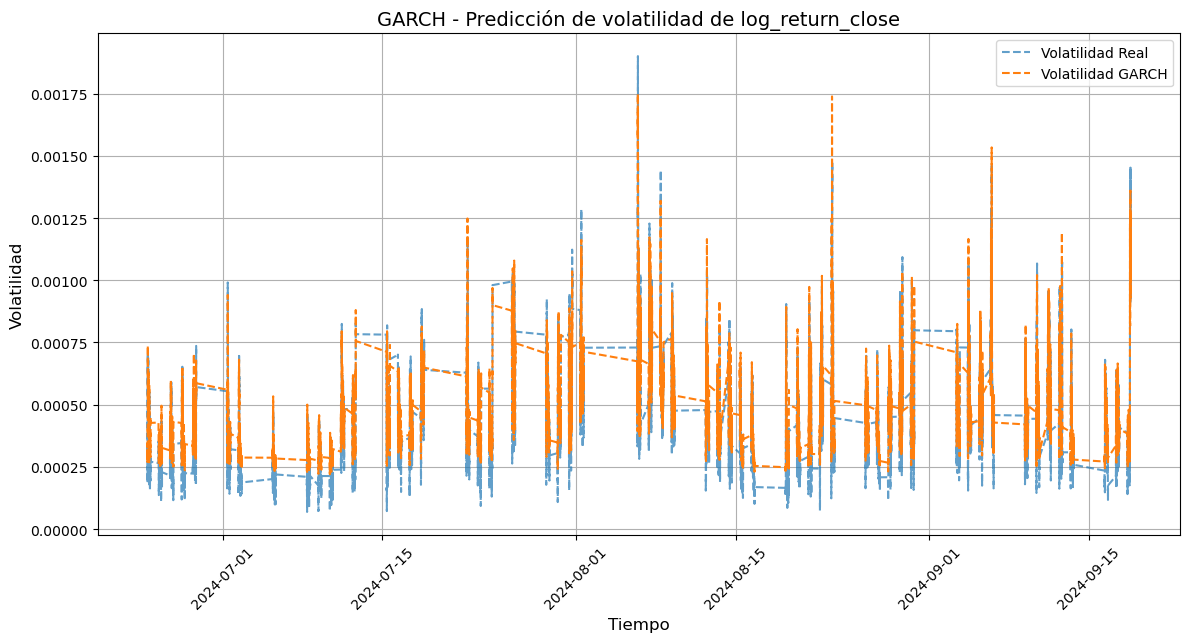


Métricas de error del modelo GARCH (volatilidad) para la serie 'log_return_close':

	MAE: 0.00013988091947376072
	RMSE: 0.0001864040253315341
	MAPE: 39.19865253823528
	R²: 0.29937898056281786


In [ ]:
#Predicciones del model_close
pred_garch_close = garch_predict(model_garch_close)
plot_garch(df_garch, 'log_return_close', pred_garch_close)
calcular_error_garch(df_garch, 'log_return_close', pred_garch_close)

##### 2.4. Predicción y error de modelo GARCH para log_return_close_diff


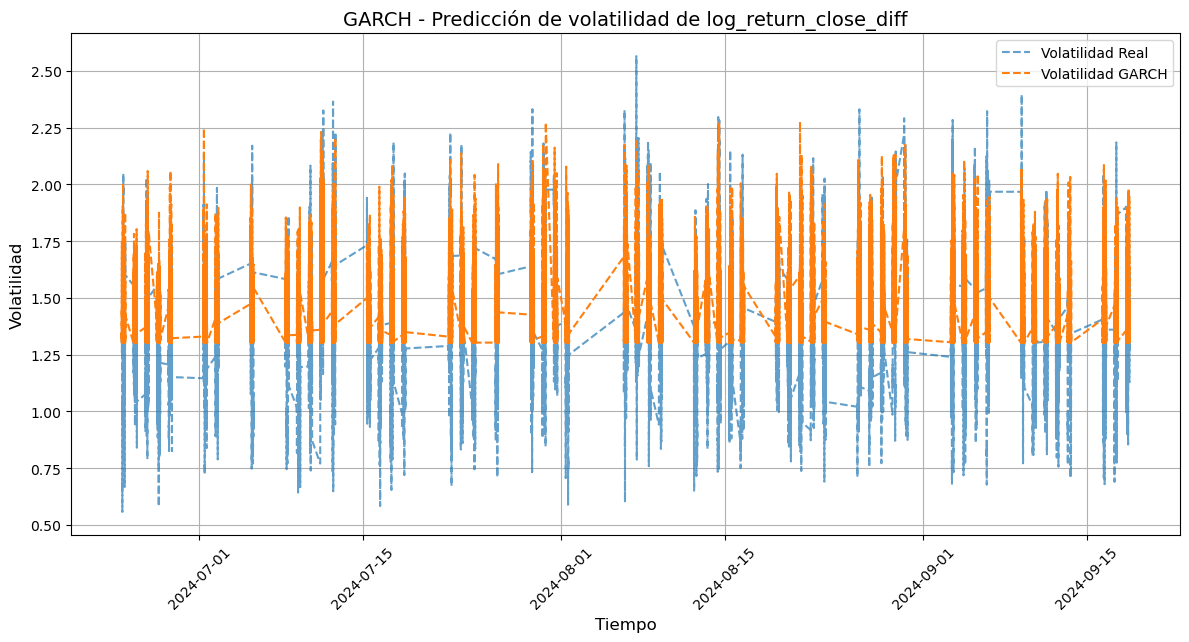


Métricas de error del modelo GARCH (volatilidad) para la serie 'log_return_close_diff':

	MAE: 0.2450938120025034
	RMSE: 0.30402112764242695
	MAPE: 18.74617088994116
	R²: 0.0245553182371141


In [ ]:
#Predicciones del model_close_diff
pred_garch_close_diff = garch_predict(model_garch_close_diff)
plot_garch(df_garch, 'log_return_close_diff', pred_garch_close_diff)
calcular_error_garch(df_garch, 'log_return_close_diff', pred_garch_close_diff)

##### 2.5. Análisis de resultados

| Métrica       | `log_return_close` | `log_return_close_diff` |
|---------------|--------------------|-------------------------|
| **MAE**       | 0.0001399          | 0.2451                  |
| **RMSE**      | 0.0001864          | 0.3040                  |
| **MAPE**      | 39.20%             | 18.75%                  |
| **R²**        | 0.2994             | 0.0246                  |

- El MAE es mucho menor para log_return_close, lo que significa que, en promedio, los errores absolutos en log_return_close son mucho menores que en log_return_close_diff. Esto sugiere que el modelo predice log_return_close de manera más precisa.

- El RMSE es también mucho menor para log_return_close, lo que indica que la dispersión de los errores cuadráticos (es decir, los errores grandes) es significativamente más baja en log_return_close que en log_return_close_diff.

- El MAPE para log_return_close_diff es más bajo, lo que indica que el modelo tiene una menor variabilidad porcentual en sus predicciones para log_return_close_diff. Sin embargo, log_return_close tiene un error absoluto mucho menor (como se ve en el MAE y RMSE).
- log_return_close tiene un R² mucho más alto, lo que indica que el modelo predice mejor los valores de la serie log_return_close en comparación con log_return_close_diff. Un R² más alto significa que el modelo captura mejor la variabilidad de los datos reales.

- En general, log_return_close tiene un rendimiento superior en términos de MAE, RMSE, y R², lo que indica que el modelo se ajusta mejor a esta serie.

- Si bien, log_return_close_diff tiene un MAPE más bajo, pero este valor no compensa las métricas de error más altas (como el MAE y RMSE) ni el R² más bajo. Esto sugiere que, aunque el modelo es menos sensible a los errores en términos de porcentaje, la precisión general de las predicciones es mejor con log_return_close.

**Basado en las métricas de error, log_return_close parece ser una mejor opción para el modelo, ya que tiene menores errores absolutos y cuadráticos y un R² más alto. Sin embargo, el MAPE más bajo en log_return_close_diff podría indicar que hay menos variabilidad en términos porcentuales, aunque el modelo globalmente tiene un ajuste menos bueno.**

#### 3. LSTM

In [ ]:
#Creo una copia del dataset df_mnq para el modelo LSTM
df_lstm=df_mnq.copy()

Siguiendo el ejemplo hecho en clase, separo mi dataset en train y test.

##### 3.1. Separación en train y test

In [ ]:
df_lstm_train = df_lstm['close'].iloc[:350]
df_lstm_test = df_lstm['close'].iloc[350:400]
#print(df_lstm_train.shape, df_lstm_test.shape)

##### 3.2. Escalamiento de datos

In [ ]:
# Asegurar forma 2D para el escalador
train_values = df_lstm_train.values.reshape(-1, 1)
test_values = df_lstm_test.values.reshape(-1, 1)

# Inicializar y ajustar el escalador
scaler = MinMaxScaler(feature_range=(0, 1))
scaler.fit(train_values)

# Transformar
df_lstm_train_scaled = scaler.transform(train_values)
df_lstm_test_scaled = scaler.transform(test_values)

##### 3.3. Generador de secuencias de tiempo

In [ ]:
# Se define el generador
n_input = 15
n_features = 1
lstm_generator = TimeseriesGenerator(df_lstm_train_scaled, df_lstm_train_scaled, length=n_input, batch_size=1)

# Aspecto del generador
X,y = lstm_generator[0]

##### 3.4. Definición de modelo LSTM y entrenamiento

In [ ]:
# Definir el modelo LSTM
model_lstm = Sequential()

#Capa LSTM
model_lstm.add(LSTM(units=100, activation='relu', input_shape=(n_input, n_features)))

# Dropout para evitar overfitting
model_lstm.add(Dropout(0.2))

# Capa de salida
model_lstm.add(Dense(units=1))

# Compilación del modelo
model_lstm.compile(optimizer='adam', loss='mean_squared_error')

# Resumen del modelo
model_lstm.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100)               40800     
                                                                 
 dropout (Dropout)           (None, 100)               0         
                                                                 
 dense (Dense)               (None, 1)                 101       
                                                                 
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# Entrenamiento del modelo
model_lstm.fit_generator(lstm_generator, epochs=50)

Epoch 1/50
335/335 [==============================] - 5s 8ms/step - loss: 0.0270
Epoch 2/50
335/335 [==============================] - 3s 8ms/step - loss: 0.0102
Epoch 3/50
335/335 [==============================] - 3s 8ms/step - loss: 0.0097
Epoch 4/50
335/335 [==============================] - 3s 8ms/step - loss: 0.0065
Epoch 5/50
335/335 [==============================] - 3s 7ms/step - loss: 0.0075
Epoch 6/50
335/335 [==============================] - 3s 7ms/step - loss: 0.0067
Epoch 7/50
335/335 [==============================] - 3s 7ms/step - loss: 0.0056
Epoch 8/50
335/335 [==============================] - 3s 7ms/step - loss: 0.0053
Epoch 9/50
335/335 [==============================] - 3s 8ms/step - loss: 0.0065
Epoch 10/50
335/335 [==============================] - 3s 7ms/step - loss: 0.0047
Epoch 11/50
335/335 [==============================] - 3s 8ms/step - loss: 0.0050
Epoch 12/50
335/335 [==============================] - 3s 7ms/step - loss: 0.0048
Epoch 13/50
335/335 [====

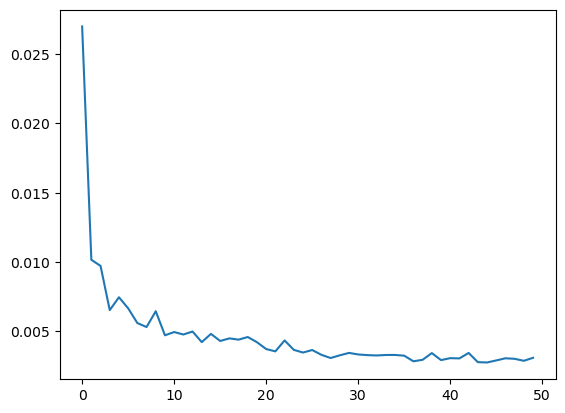

In [ ]:
#Ploteo de loss
plt.plot(range(len(model_lstm.history.history['loss'])),model_lstm.history.history['loss'])

##### 3.5. Evaluación de modelo

In [ ]:
# Tomar los últimos n_input valores para la evaluación
lstm_first_eval_batch = df_lstm_train_scaled[-n_input:]

# Convertir a array y hacer reshape a (1, n_input, n_features)
lstm_first_eval_batch = lstm_first_eval_batch.reshape((1, n_input, n_features))

# Predecir
prediccion = model_lstm.predict(lstm_first_eval_batch)

print(prediccion)

1/1 [==============================] - 0s 414ms/step
[[0.0296753]]


In [ ]:
df_lstm_test_scaled[0]

array([0.03245192])

In [ ]:
lstm_test_predictions = []

# Tomar los últimos n_input valores para la evaluación
lstm_first_eval_batch = df_lstm_train_scaled[-n_input:]
lstm_current_batch = lstm_first_eval_batch.reshape((1, n_input, n_features))

for i in range(len(df_lstm_test)):

    # Se obtiene la predicción 1 paso hacia adelante
    lstm_current_pred = model_lstm.predict(lstm_current_batch, verbose=0)[0]

    # Se guarda la predicción
    lstm_test_predictions.append(lstm_current_pred)

    # Se actualiza el lote
    lstm_current_batch = np.append(lstm_current_batch[:,1:,:],[[lstm_current_pred]],axis=1)

##### 3.6. Transformación

In [ ]:
lstm_true_predictions = scaler.inverse_transform(lstm_test_predictions)
# Convertir la Serie a DataFrame
df_lstm_test = df_lstm_test.to_frame()
df_lstm_test = df_lstm_test.tail(len(lstm_true_predictions))
df_lstm_test['Predictions'] = lstm_true_predictions

##### 3.7. Ploteo y medición de error

In [ ]:
def calcular_error_lstm(y_real, y_pred, imprimir=True):
    """
    Calcula MAE, MSE y RMSE entre dos series de valores reales y predichos.

    Parámetros:
    -----------
    y_real : array-like
        Valores reales (por ejemplo: precios reales).
    y_pred : array-like
        Valores predichos por el modelo.
    imprimir : bool
        Si es True, imprime las métricas. Si es False, las retorna.

    Retorna (si imprimir=False):
    -----------------------------
    mae, mse, rmse : float
    """
    mae = mean_absolute_error(y_real, y_pred)
    mse = mean_squared_error(y_real, y_pred)
    rmse = np.sqrt(mse)

    print('\nMétricas de error del modelo LSTM para la serie close:\n')

    if imprimir:
        print(f"\tMAE  = {mae:.4f}")
        print(f"\tMSE  = {mse:.4f}")
        print(f"\tRMSE = {rmse:.4f}")
    else:
        return mae, mse, rmse


In [ ]:
def ploteo_lstm(df, col_real='close', col_pred='Predictions', titulo='LSTM: Valor Real vs Predicción'):
    """
    Grafica la comparación entre valores reales y predichos a lo largo del tiempo.

    Parámetros:
    -----------
    df : DataFrame
        DataFrame que contiene las columnas de valores reales y predichos.
    col_real : str
        Nombre de la columna con los valores reales.
    col_pred : str
        Nombre de la columna con las predicciones.
    titulo : str
        Título del gráfico.
    """
    plt.figure(figsize=(14, 6))
    plt.plot(df.index, df[col_real], label='Valor Real')
    plt.plot(df.index, df[col_pred], label='Predicción')
    plt.title(titulo)
    plt.xlabel('Tiempo')
    plt.ylabel('Precio')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

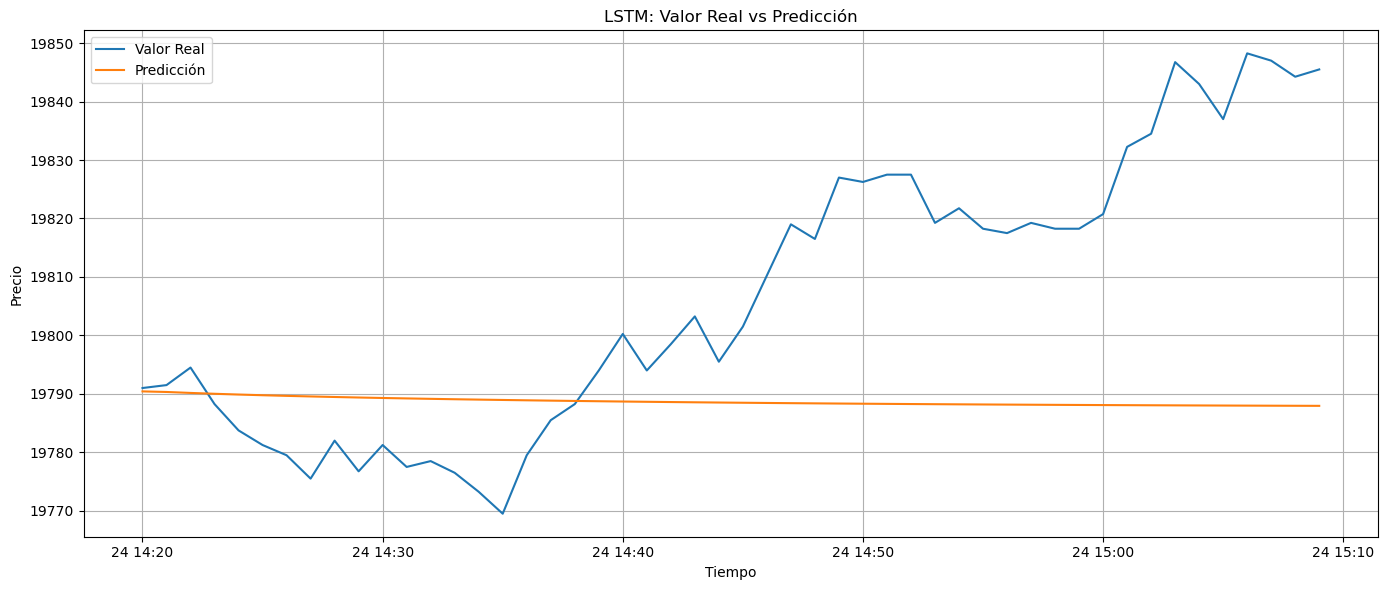

Metricas de modelo LSTM:

	MAE  = 23.9024
	MSE  = 901.3132
	RMSE = 30.0219


In [ ]:
ploteo_lstm(df_lstm_test)
calcular_error_lstm(df_lstm_test['close'].values, df_lstm_test['Predictions'].values, imprimir=True)

### c. Generación de pronósticos por cada modelo, evaluación y comparación.


#### 1. Modelo ARIMA (0,0,4) para serie 'close'

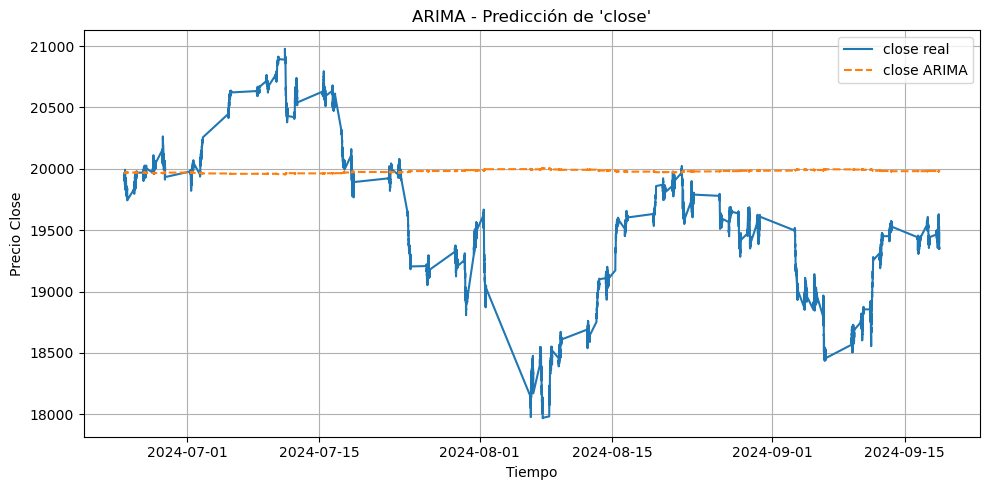


Métricas de error del modelo ARIMA (0,0,4) para la serie 'close':

	MAE: 625.5454944545269
	RMSE: 779.0262785190007
	MAPE: 3.257203629861632
	R²: -0.4353192935420831


In [ ]:
predicciones, reales = predicciones_arima(df_arima, model_arima)
calcular_error_arima(predicciones, reales)

#### 2. Modelo GARCH para volatilidad de 'close'

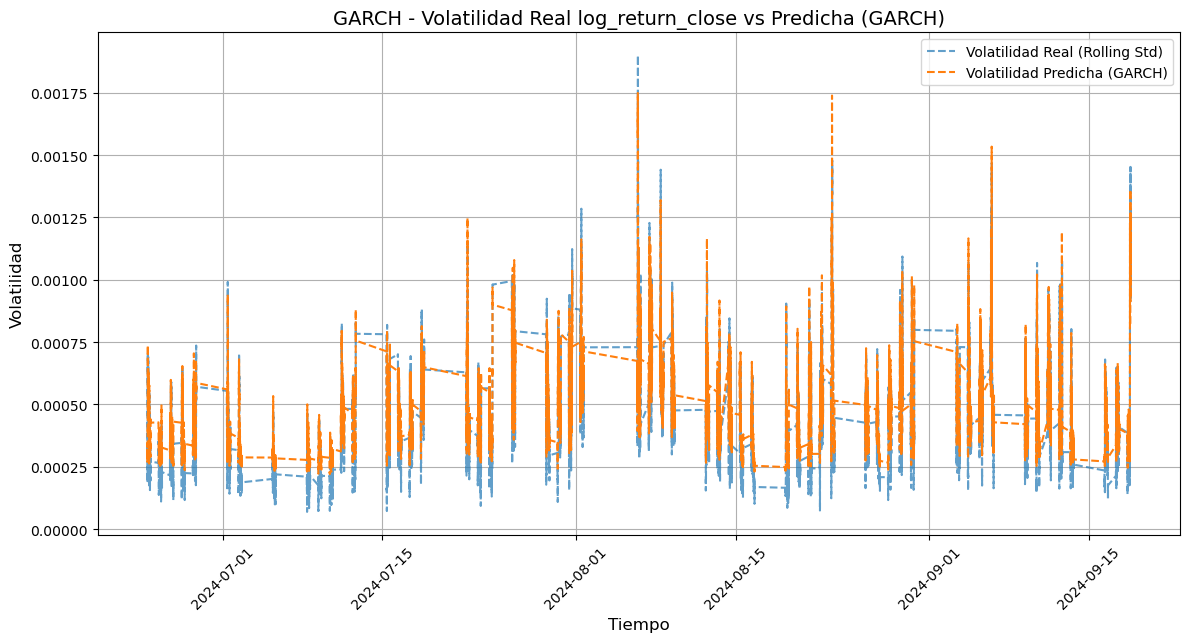


Métricas de error del modelo GARCH (volatilidad) para la serie 'log_return_close':

	MAE: 0.00013988091947376072
	RMSE: 0.0001864040253315341
	MAPE: 39.19865253823528
	R²: 0.29937898056281786


In [ ]:
plot_garch(df_garch, 'log_return_close', pred_garch_close)
calcular_error_garch(df_garch, 'log_return_close', pred_garch_close)

#### 3. Modelo LSTM para 'close'

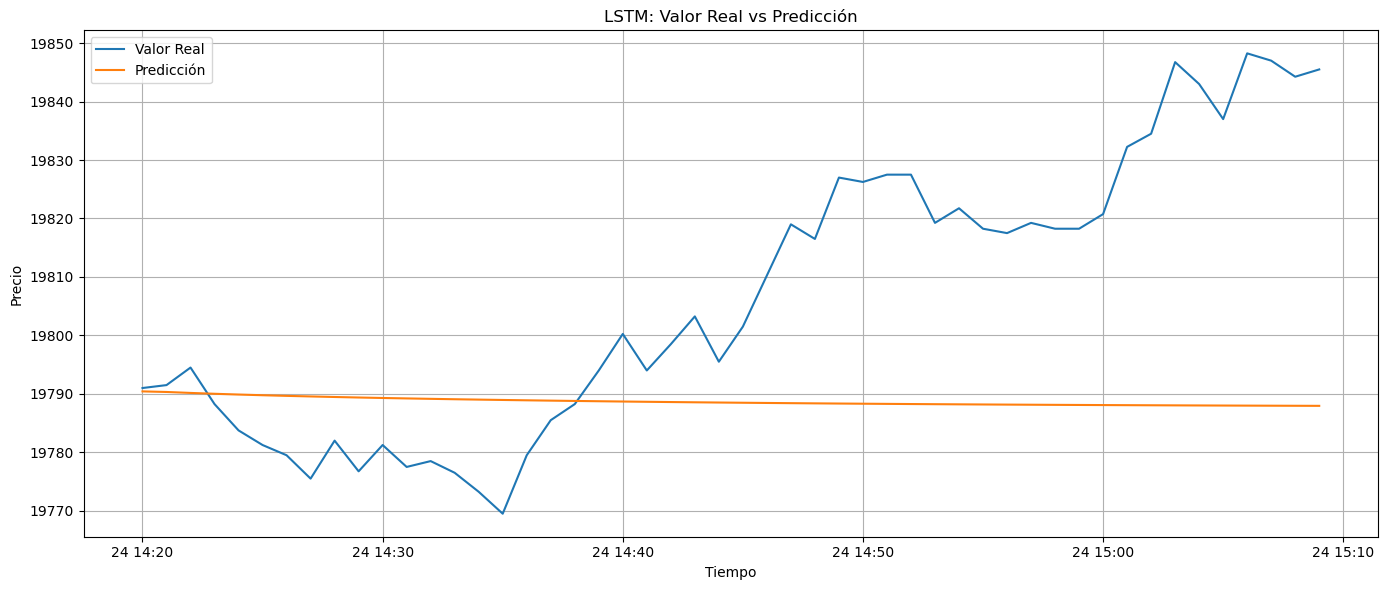

Metricas de modelo LSTM:

	MAE  = 23.9024
	MSE  = 901.3132
	RMSE = 30.0219


In [ ]:
ploteo_lstm(df_lstm_test)
calcular_error_lstm(df_lstm_test['close'].values, df_lstm_test['Predictions'].values, imprimir=True)

## Comparación de Modelos para la Serie 'close'

### 1. Modelo ARIMA (0,0,4)

- **Serie modelada**: `close` (sin diferenciación)
- **Predicción**: determinista, basada en regresión sobre valores pasados.
- **Gráfico**: la predicción muestra una línea plana, sin seguir la dinámica real.

**Métricas:**

- MAE: 625.55  
- RMSE: 779.03  
- MAPE: 3.26%  
- R²: -0.435

**Conclusión:**  
El modelo ARIMA no logró captar la estructura del precio. Su error alto y el R² negativo indican un mal ajuste. Es probable que la serie necesite ser transformada o diferenciada antes de aplicar este modelo.

---

### 2. Modelo GARCH (1,1)

- **Serie modelada**: `log_return_close`
- **Predicción**: volatilidad condicional (`σ_t²`)
- **Gráfico**: logra capturar adecuadamente los picos de volatilidad real.

**Métricas:**

- MAE: 0.00013988  
- RMSE: 0.00018640  
- MAPE: 39.20%  
- R²: 0.299

**Conclusión:**  
Aunque el MAPE es alto (debido a valores pequeños en la base), el modelo captura correctamente la estructura de la volatilidad. Es adecuado para estimar riesgo, pero no se puede usar directamente para predecir precios.

---

### 3. Modelo LSTM

- **Serie modelada**: `close`
- **Predicción**: directa sobre el precio, utilizando secuencias de pasos anteriores.
- **Gráfico**: la predicción es casi constante, sin seguir el comportamiento real de la serie.

**Métricas:**

- MAE: 23.90  
- RMSE: 30.02  

**Conclusión:**  
El modelo LSTM presenta un subajuste. Las posibles causas incluyen una ventana de entrada muy corta, escaso entrenamiento por día o arquitectura poco profunda. No logró capturar la dinámica de corto plazo del precio.

---

## Resumen Comparativo

| Modelo | MAE      | RMSE     | MAPE    | R²       | Comentario |
|--------|----------|----------|---------|----------|------------|
| ARIMA  | 625.55   | 779.03   | 3.26%   | -0.435   | No capta la dinámica real del precio |
| GARCH  | 0.00014  | 0.00019  | 39.20%  | 0.299    | Buen modelo para estimar volatilidad |
| LSTM   | 23.90    | 30.02    | —       | —        | Subajuste, predicción poco dinámica |

---

## Recomendaciones

- **ARIMA**: Evaluar una versión diferenciada o estacional (SARIMA).
- **GARCH**: Integrarlo con un modelo de media (ej. ARIMA + GARCH).
- **LSTM**: Mejorar el preprocesamiento, usar ventanas móviles y ajustar la arquitectura.